
# Part I: Basics



## Setup

First we install the `graphviz` package:

In [ ]:
!apt-get install graphviz
!pip install graphviz

## Imports and data structures

We import Numpy and Pyplot, and then we define the basic data structures for
this tutorial.

In [1]:
#@title Imports

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [76]:
#@title Data structures

import graphviz
import copy
from random import random


class MinCut:
  """A representation of an event in a probability tree."""

  def __init__(self, root, t=frozenset(), f=frozenset()):
    self._root = root
    self.t = t
    self.f = f

  def __str__(self):

    true_elements = ', '.join([str(id) for id in sorted(self.t)])
    false_elements = ', '.join([str(id) for id in sorted(self.f)])
    return '{true: {' + true_elements + '}, false: {' + false_elements + '}}'

  def __reptr__(self):
    return self.__str__()

  # Proposition
  def prop(root, statement):
    cond_lst = Node._parse_statements(statement)

    # Complain if more than one statement.
    if len(cond_lst) != 1:
      raise Exception('\'prop\' takes one and only one statement.')
      return None

    # Remove list envelope.
    cond = cond_lst[0]

    # Recurse.
    return MinCut._prop(root, root, cond)

  def _prop(root, node, cond):
    # Take var and val of condition.
    condvar, condval = cond

    # Search for variable.
    for var, val in node.assign:
      if condvar == var:
        if condval == val:
          return MinCut(root, frozenset([node.id]), frozenset())
        else:
          return MinCut(root, frozenset(), frozenset([node.id]))

    # If we reach a leaf node and the variable isn't resolved,
    # raise an exception.
    if not node.children:
      msg = 'Node ' + str(node.id) + ': ' \
          + 'min-cut for condition "' + condvar + ' = ' \
          + condval + '" is undefined.'
      raise Exception(msg)

    # Variable not found, recurse.
    t_set = frozenset()
    f_set = frozenset()
    for child in node.children:
      _, subnode = child
      subcut = MinCut._prop(root, subnode, cond)
      t_set = t_set.union(subcut.t)
      f_set = f_set.union(subcut.f)

    # Consolidate into node if children are either only true or false nodes.
    cut = MinCut(root, t_set, f_set)
    if not cut.f:
      cut.t = frozenset([node.id])
    elif not cut.t:
      cut.f = frozenset([node.id])

    return cut

  # Negation
  def neg(self):
    return MinCut(self._root, t=self.f, f=self.t)

  def __invert__(self):
    return self.neg()

  # Conjunction
  def conj(root, cut1, cut2):
    return MinCut._conj(root, root, cut1, cut2, False, False)

  def _conj(root, node, cut1, cut2, end1=False, end2=False):
    # Base case.
    if (node.id in cut1.f) or (node.id in cut2.f):
      return MinCut(root, frozenset(), frozenset([node.id]))
    if node.id in cut1.t:
      end1 = True
    if node.id in cut2.t:
      end2 = True
    if end1 and end2:
      return MinCut(root, frozenset([node.id]), frozenset())

    # Recurse.
    t_set = frozenset()
    f_set = frozenset()
    for _, subnode in node.children:
      subcut = MinCut._conj(root, subnode, cut1, cut2, end1, end2)
      t_set = t_set.union(subcut.t)
      f_set = f_set.union(subcut.f)

    # Consolidate into node if children are either only true or false nodes.
    cut = MinCut(root, t_set, f_set)
    if not cut.f:
      cut.t = frozenset([node.id])
    elif not cut.t:
      cut.f = frozenset([node.id])
    return cut

  def __and__(self, operand):
    return MinCut.conj(self._root, self, operand)

  # Disjunction
  def disj(root, cut1, cut2):
    return MinCut.neg(MinCut.conj(root, MinCut.neg(cut1), MinCut.neg(cut2)))

  def __or__(self, operand):
    return MinCut.disj(self._root, self, operand)

  # Causal dependence
  def precedes(root, cut_c, cut_e):
    return MinCut._precedes(root, root, cut_c, cut_e, False)

  def _precedes(root, node, cut_c, cut_e, found_c):
    # Base case.
    if not found_c:
      if (node.id in cut_e.t or node.id in cut_e.f or node.id in cut_c.f):
        return MinCut(root, frozenset(), frozenset([node.id]))
      if (node.id in cut_c.t):
        found_c = True
    if found_c:
      if (node.id in cut_e.t):
        return MinCut(root, frozenset([node.id]), frozenset())
      if (node.id in cut_e.f):
        return MinCut(root, frozenset(), frozenset([node.id]))

    # Recursion.
    t_set = frozenset()
    f_set = frozenset()
    for _, subnode in node.children:
      subcut = MinCut._precedes(root, subnode, cut_c, cut_e, found_c)
      t_set = t_set.union(subcut.t)
      f_set = f_set.union(subcut.f)

    # Consolidate into node if children are either only true or false nodes.
    cut = MinCut(root, t_set, f_set)
    if not cut.f:
      cut.t = frozenset([node.id])
    elif not cut.t:
      cut.f = frozenset([node.id])
    return cut

  def __lt__(self, operand):
    return MinCut.precedes(self._root, self, operand)


class Critical:
  """A representation of the critical set associated to an event."""

  # Constructor
  def __init__(self, s=frozenset()):
    self.s = s

  def __str__(self):
    elements = ', '.join([str(id) for id in sorted(self.s)])
    return '{' + elements + '}'

  def __reptr__(self):
    return self.__str__()

  def critical(root, cut):
    _, crit = Critical._critical(root, cut)
    return crit

  def _critical(node, cut):
    # Base case.
    if node.id in cut.t:
      return (False, Critical(frozenset()))
    if node.id in cut.f:
      return (True, Critical(frozenset()))
    # Recurse.
    s = frozenset()
    for _, subnode in node.children:
      incut, subcrit = Critical._critical(subnode, cut)
      if incut:
        s = s.union(frozenset([node.id]))
      else:
        s = s.union(subcrit.s)

    return (False, Critical(s))


class Node:
  """A node in probability tree."""

  # Constructor.
  def __init__(self, uid, statements, children=None):
    # Automatically assigned ID.
    self.id = uid

    # Assignments.
    if isinstance(statements, str):
      self.assign = Node._parse_statements(statements)
    else:
      self.assign = statements

    # Children.
    if children is None:
      self.children = []
    else:
      self.children = children

  # Parse statements.
  def _parse_statements(statements):
    statement_list = statements.split(',')
    pair_list = [x.split('=') for x in statement_list]
    assign = [(var.strip(), val.strip()) for var, val in pair_list]
    return assign

  # Sample.
  def sample(self):
    return self._sample(dict())

  def _sample(self, smp):
    # Add new assignments.
    newsmp = {var: val for var, val in self.assign}
    smp = dict(smp, **newsmp)

    # Base case.
    if not self.children:
      return smp

    # Recurse.
    rnum = random()
    for child in self.children:
      subprob, subnode = child
      rnum -= subprob
      if rnum <= 0:
        return subnode._sample(smp)

    # Something went wrong: probabilities aren't normalized.
    msg = 'Node ' + str(self.id) + ': ' \
      + 'probabilities of transitions do not add up to one.'
    raise Exception(msg)

  # Insert.
  def insert(self, prob, node):
    self.children.append((prob, node))

  # Compute probability of cut.
  def prob(self, cut):
    return self._prob(cut, 1.0)

  def _prob(self, cut, prob):
    # Base case.
    if self.id in cut.t:
      return prob
    if self.id in cut.f:
      return 0.0

    # Recurse.
    probsum = 0.0
    for child in self.children:
      subprob, subnode = child
      resprob = subnode._prob(cut, prob * subprob)
      probsum += resprob

    return probsum

  # Return a dictionary with all the random variables and their values.
  def rvs(self):
    sts = dict()
    return self._rvs(sts)

  def _rvs(self, sts):
    for var, val in self.assign:
      if not (var in sts):
        sts[var] = list()
      if not (val in sts[var]):
        sts[var].append(val)

    for _, subnode in self.children:
      sts = subnode._rvs(sts)

    return sts

  # Auxiliary function for computing the list of children.
  def _normalize_children(children, probsum, logsum):
    newchildren = None
    if probsum > 0.0:
      newchildren = [
          (subprob / probsum, subnode) for _, subprob, subnode in children
      ]
    else:
      newchildren = [
          (sublog / logsum, subnode) for sublog, _, subnode in children
      ]
    return newchildren

  # Conditioning
  def see(self, cut):
    root = copy.deepcopy(self)
    root._see(cut, 1.0)
    return root

  def _see(self, cut, prob):
    # Base case.
    if self.id in cut.t:
      newnode = Node(self.id, self.assign)
      return (1.0, prob)
    if self.id in cut.f:
      newnode = Node(self.id, self.assign)
      return (0.0, 0.0)

    # Recurse.
    newchildren = []
    probsum = 0.0
    logsum = 0.0
    for subprob, subnode in self.children:
      reslog, resprob = subnode._see(cut, prob * subprob)

      newchildren.append((reslog, resprob, subnode))
      logsum += reslog
      probsum += resprob

    # Normalize.
    self.children = Node._normalize_children(newchildren, probsum, logsum)

    return (1.0, probsum)

  # Causal intervention
  def do(self, cut):
    root = copy.deepcopy(self)
    root._do(cut)
    return root

  def _do(self, cut):
    # Base case.
    if self.id in cut.t:
      return True
    if self.id in cut.f:
      return False

    # Recurse.
    newchildren = []
    probsum = 0.0
    logsum = 0.0
    for subprob, subnode in self.children:
      resdo = subnode._do(cut)

      if resdo:
        newchildren.append((1.0, subprob, subnode))
        probsum += subprob
        logsum += 1.0
      else:
        newchildren.append((0.0, 0.0, subnode))

    # Normalize.
    self.children = Node._normalize_children(newchildren, probsum, logsum)

    return (1.0, probsum)

  # Counterfactual/subjunctive conditional
  def cf(self, root_prem, cut_subj):
    root_subj = self.do(cut_subj)
    root_subj._cf(root_prem, cut_subj)
    return root_subj

  def _cf(self, prem, cut):
    # Base case.
    if self.id in cut.t:
      return True
    if self.id in cut.f:
      return False

    # Recurse.
    critical = False

    for child, child_prem in zip(self.children, prem.children):
      (_, subnode) = child
      (_, subnode_prem) = child_prem
      in_do = subnode._cf(subnode_prem, cut)
      if not in_do:
        critical = True
        continue

    # Pick children if node is critical.
    if not critical:
      self.children = [
          (subprob, subnode)
          for (_, subnode), (subprob, _) in zip(self.children, prem.children)
      ]

    return True

  # Show probability tree.
  def show(self, show_id=False, show_prob=False, cut=None, crit=None):
    # Initialize Digraph.
    graph_attr = {
        'bgcolor': 'White',
        'rankdir': 'LR',
        'nodesep': '0.1',
        'ranksep': '0.3',
        'sep': '0'
    }
    node_attr = {
        'style': 'rounded',
        'shape': 'box',
        'height': '0.1',
        'width': '0.5',
        'fontsize': '10',
        'margin': '0.1, 0.02'
    }
    edge_attr = {'fontsize': '10'}
    g = graphviz.Digraph(
        'g',
        format='svg',
        graph_attr=graph_attr,
        node_attr=node_attr,
        edge_attr=edge_attr)

    # Recursion.
    return self._show(
        g, 1.0, show_id=show_id, show_prob=show_prob, cut=cut, crit=crit)

  def _show(self, g, prob, show_id=False, show_prob=False, cut=None, crit=None):
    # Create label.
    labels = [name + ' = ' + value for name, value in self.assign]
    node_label = '\n'.join(labels)
    if show_id:
      node_label = str(self.id) + '\n' + node_label
    if show_prob:
      node_label = node_label + '\np = ' + '{0:.3g}'.format(prob)

    # Decorate node.
    attr = {'style': 'filled, rounded', 'fillcolor': 'WhiteSmoke'}
    if not (cut is None):
      if self.id in cut.t:
        attr = {'style': 'filled, rounded', 'fillcolor': 'AquaMarine'}
      elif self.id in cut.f:
        attr = {'style': 'filled, rounded', 'fillcolor': 'LightCoral'}
    if not (crit is None):
      if self.id in crit.s:
        attr = {'style': 'filled, rounded', 'fillcolor': 'Plum'}
    g.node(str(self.id), label=node_label, **attr)

    # Recurse.
    for child in self.children:
      subprob, subnode = child
      subnode._show(
          g,
          prob * subprob,
          show_id=show_id,
          show_prob=show_prob,
          cut=cut,
          crit=crit)
      g.edge(str(self.id), str(subnode.id), label='{0:.3g}'.format(subprob))

    return g

  def find(self, uid):
    if self.id == uid:
      return self

    for child in self.children:
      subprob, subnode = child
      found_node = subnode.find(uid)
      if found_node is not None:
        return found_node

    return None


class PTree:
  """A probability tree."""

  def __init__(self):
    """Create a probability tree."""
    self._root = None
    self._count = 0

  def root(self, statements, children=None):
    """Sets the root node.

        Parameters
        ----------
        statements : str
            A string containing a comma-separated list of statements of
            the form "var = val", such as "X=1, Y=0". These are the
            values resolved by the root node.
        children : list((float, Node)), (default: None)
            A list of (probability, child node) pairs. These are the root
            node's children and their transition probabilities.

        Returns
        -------
        Node
            the root node of the probability tree.
        """
    self._count += 1
    self._root = Node(self._count, statements, children)
    return self._root

  def child(self, prob, statements, children=None):
    """Create a child node and its transition probability.

        Parameters
        ----------
        prob : float
            The probability of the transition
        statements : str
            A string containing a comma-separated list of statements of
            the form "var = val", such as "X=1, Y=0". These are the
            values resolved by the child node.
        children : list((float, Node)), (default: None)
            A list of (probability, child node) pairs to be set as the
            children of the node.

        Returns
        -------
        Node
            the created node.
        """
    self._count += 1
    return (prob, Node(self._count, statements, children))

  def get_root(self):
    """Return the root node.

        Returns
        -------
        Node
            the root node of the probability tree.
        """
    return self._root

  def show(self, show_id=False, show_prob=False, cut=None, crit=None):
    """Returns a graph of the probability tree.

        Parameters
        ----------
        show_id: Bool (default: False)
            If true, display the unique id's.
        show_prob : Bool (default: False)
            If true, display the node probabilities.
        cut : MinCut (default: None)
            If a MinCut is given, then display it.
        crit : Critical (default: None)
            If a Critical set is given, then show it.

        Returns
        -------
        Node
            the created node.
        """
    return self._root.show(
        show_id=show_id, show_prob=show_prob, cut=cut, crit=crit)

  def rvs(self):
    """Return a dictionary with all the random variables and their values.

        Returns
        -------
        dict(str: list)
            A dictionary with all the random variables pointing at lists
            containing their possible values.
        """
    return self._root.rvs()

  def rv(self, var):
    """Return a probability distribution for a given random variable.

        Parameters
        ----------
        var: str
            A string containing the name of the random variable.

        Returns
        -------
        list((float, str))
            A list with pairs (prob, val), where prob and val are the
            probability
            and the value of the random variable.
        """
    return [(self.prob(self.prop(var + ' = ' + val)), val)
            for val in self.rvs()[var]]

  def expect(self, var):
    """Return the expected value of a random variable.

        Parameters
        ----------
        var: str
            A string containing the name of the random variable.

        Returns
        -------
        float
            The expected value of the random variable.
        """
    e = 0.0
    for prob, val in self.rv(var):
      e += prob * float(val)
    return e

  def find(self, uid):
    """Return a node with given unique identifier.

        Parameters
        ----------
        uid: int
            Identifier of the node to be returned.

        Returns
        -------
        Node or None
            Returns the node if found, otherwise None.
        """
    return self._root.find(uid)

  def prop(self, statement):
    """Returns min-cut of a statement.

        Parameters
        ----------
        statement: str
            A single statement of the form "var = val", such as "X = 1".

        Returns
        -------
        MinCut
            the min-cut of the event corresponding to the statement.
        """
    return MinCut.prop(self._root, statement)

  def critical(self, cut):
    """Returns critical set of a min-cut.

        Parameters
        ----------
        cut: MinCut
            A min-cuts.

        Returns
        -------
        Critical
            the critical set for the min-cut.
        """
    return Critical.critical(self._root, cut)

  def sample(self):
    """Sample a realization.
    
    Returns
    -------
    dict((str:str))
        A dictionary of bound random variables such as

            { 'X': '1', 'Y': '0' }.
    """
    return self._root.sample()

  def prob(self, cut):
    """Compute probability of a min-cut.

        Parameters
        ----------
        cut: MinCut
            A min-cut for an event.

        Returns
        -------
        float
            The probability of the event of the min-cut.
        """
    return self._root.prob(cut)

  def see(self, cut):
    """Return a probability tree conditioned on a cut.

        Parameters
        ----------
        cut: MinCut
            A min-cut for an event.

        Returns
        -------
        PTree
            A new probability tree.
        """
    newptree = PTree()
    newptree._root = self._root.see(cut)
    return newptree

  def do(self, cut):
    """Intervene on a cut.

        Parameters
        ----------
        cut: MinCut
            A min-cut for an event.

        Returns
        -------
        float
            A new probability tree.
        """
    newptree = PTree()
    newptree._root = self._root.do(cut)
    return newptree

  def cf(self, tree_prem, cut_subj):
    """Return a subjunctive conditional tree.

        Parameters
        ----------
        tree_prem: PTree
            A probality tree representing the premises for the subjunctive
            evaluation.
            This probability tree must have been obtained through operations on
            the
            base probability tree.
        cut_do: MinCut
            A min-cut for an event. This min-cut is the subjunctive condition of
            the
            counterfactual.

        Returns
        -------
        float
            A new probability tree.
        """
    newptree = PTree()
    newptree._root = self._root.cf(tree_prem._root, cut_subj)
    return newptree

  def fromFunc(func, root_statement=None):
    """Build a probability tree from a factory function.

        Building probability trees can be difficult, especially when we have
        to manually specify all its nodes. To simplify this, `fromFunc` allows
        building a probability tree using a factory function. A factory
        function is a function that:

        - receives a dictionary of bound random variables, such as

            { 'X': '1', 'Y': '0' }

        - and returns either `None` if a leaf has been reached, or a list
          of transitions and their statements, such as

            [(0.3, 'Z = 0'), (0.2, 'Z = 1'), (0.5, 'Z = 2')].

        Such a factory function contains all the necessary information for
        building a probability tree.

        The advantage of using a factory function is that we can exploit
        symmetries (such as conditional independencies) to code a much
        more compact description of the probability tree.


        Parameters
        ----------
        func: Function: dict((str: str)) -> list((float, str))
            A probality tree factory function.

        root_statement: str (default: None)
            A string containing the statement (e.g. 'root = 0')
            for the root node. If `None`, 'Ω = 1' is used.

        Returns
        -------
        PTree
            A new probability tree.
        """
    if not root_statement:
      root_statement = 'O = 1'

    tree = PTree()
    bvars = dict(Node._parse_statements(root_statement))
    tree.root(root_statement, tree._fromFunc(func, bvars))
    return tree

  def _fromFunc(self, func, bvars):
    """Auxiliary method for PTree.fromFunc()."""

    transition_list = func(bvars)
    if not transition_list:
      return None
    children = []
    for prob, statement in transition_list:
      add_vars = dict(Node._parse_statements(statement))
      new_bvars = {**bvars, **add_vars}
      #print(f'New bvars {bvars} from statement {statement}')
      res = self._fromFunc(func, new_bvars)
      children.append(self.child(prob, statement, res))
    return children

Now we observe that the probabilities of the burglar and earthquake
events are exactly as the base rates - we have severed the
causal dependencies connecting those events with the alarm.

# Firing squad (deterministic)

Consider a two-man firing squad as depicted in Figure 7.1, where $A, B, C, D$, and $U$ stand for the following propositions:
* $U$ = court orders the execution;
* $C$ = captain gives a signal;
* $A$ = rifleman A shoots;
* $B$ = rifleman B shoots;
* $D$ = prisoner dies.

Assume that the court’s decision is unknown, that both riflemen are accurate, alert, and law-abiding, and that the prisoner is not likely to die from fright or other extraneous causes. We wish to construct a formal representation of the story, so that the following sentences can be evaluated mechanically.

### Misspecified Firing squad story

Initially, I thought that in order to convert the firing squad DAG to a probability tree, I had to specify $A$ and $B$ as a single node, but this turns out to be a misspecification of the Firing Squad story.  If both $A$ and $B$ depend on $C$ for their values, then it doesn't matter in which order $A$ and $B$ are defined. As long as they are equivalent topological sorts of the DAG, they both produce the same answer to all probabilistic, interventional and counterfactual queries.

In [90]:
def misspecified_firing_squad(bvar):
    # Define the Court order and Nervous Rifleman A events.
    #new_bvars = None
    if 'CourtOrder' not in bvar:
        p = 0.5   # Probability of Court Order
        return [(1-p,'CourtOrder=0'), 
                (p,'CourtOrder=1')]
    
    elif 'Captain' not in bvar:
        if bvar['CourtOrder'] == '0':
            return [(1,'Captain=0'),
                    (0,'Captain=1')]
        else:
            return [(0,'Captain=0'),
                    (1,'Captain=1')]
    elif 'RiflemanA' not in bvar and 'RiflemanB' not in bvar:
        if bvar['Captain'] == '0':
            return [(1,'RiflemanA=0,RiflemanB=0'),
                    (0,'RiflemanA=1,RiflemanB=0'),
                    (0,'RiflemanA=0,RiflemanB=1'),
                    (0,'RiflemanA=1,RiflemanB=1')]
        else:
            return [(0,'RiflemanA=0,RiflemanB=0'),
                    (0,'RiflemanA=1,RiflemanB=0'),
                    (0,'RiflemanA=0,RiflemanB=1'),
                    (1, 'RiflemanA=1,RiflemanB=1')]
    elif 'DeadPrisoner' not in bvar:
        if bvar['RiflemanA']  == '0' and bvar['RiflemanB'] == '0':
            return [(1,'DeadPrisoner=0'),
                    (0,'DeadPrisoner=1')]
        else:
            return [(0,'DeadPrisoner=0'),
                    (1,'DeadPrisoner=1')]

    else:
        return None


### Firing squad story with A defined first

In [159]:
def A_first_firing_squad(bvar):
    # Define the Court order and Nervous Rifleman A events.
    #new_bvars = None
    if 'CourtOrder' not in bvar:
        p = 0.5   # Probability of Court Order
        return [(1-p,'CourtOrder=0'), 
                (p,'CourtOrder=1')]
    
    elif 'Captain' not in bvar:
        if bvar['CourtOrder'] == '0':
            return [(1,'Captain=0'),
                    (0,'Captain=1')]
        else:
            return [(0,'Captain=0'),
                    (1,'Captain=1')]
    elif 'RiflemanA' not in bvar:
        if bvar['Captain'] == '0':
            return [(1,'RiflemanA=0'),
                    (0,'RiflemanA=1'),
                    ]
        else:
            return [(0,'RiflemanA=0'),
                    (1,'RiflemanA=1'),
                    ]
    elif 'RiflemanB' not in bvar:
        if bvar['Captain'] == '0':
            return [(1,'RiflemanB=0'),
                    (0,'RiflemanB=1'),
                    ]
        else:
            return [(0,'RiflemanB=0'),
                    (1,'RiflemanB=1'),
                    ]
    elif 'DeadPrisoner' not in bvar:
        if bvar['RiflemanA']  == '0' and bvar['RiflemanB'] == '0':
            return [(1,'DeadPrisoner=0'),
                    (0,'DeadPrisoner=1')]
        else:
            return [(0,'DeadPrisoner=0'),
                    (1,'DeadPrisoner=1')]

    else:
        return None


### Firing squad story with B defined first

In [160]:
def B_first_firing_squad(bvar):
    # Define the Court order and Nervous Rifleman A events.
    #new_bvars = None
    if 'CourtOrder' not in bvar:
        p = 0.5   # Probability of Court Order
        return [(1-p,'CourtOrder=0'), 
                (p,'CourtOrder=1')]
    
    elif 'Captain' not in bvar:
        if bvar['CourtOrder'] == '0':
            return [(1,'Captain=0'),
                    (0,'Captain=1')]
        else:
            return [(0,'Captain=0'),
                    (1,'Captain=1')]
   
    elif 'RiflemanB' not in bvar:
        if bvar['Captain'] == '0':
            return [(1,'RiflemanB=0'),
                    (0,'RiflemanB=1'),
                    ]
        else:
            return [(0,'RiflemanB=0'),
                    (1,'RiflemanB=1'),
                    ]
    elif 'RiflemanA' not in bvar:
        if bvar['Captain'] == '0':
            return [(1,'RiflemanA=0'),
                    (0,'RiflemanA=1'),
                    ]
        else:
            return [(0,'RiflemanA=0'),
                    (1,'RiflemanA=1'),
                    ]
    elif 'DeadPrisoner' not in bvar:
        if bvar['RiflemanA']  == '0' and bvar['RiflemanB'] == '0':
            return [(1,'DeadPrisoner=0'),
                    (0,'DeadPrisoner=1')]
        else:
            return [(0,'DeadPrisoner=0'),
                    (1,'DeadPrisoner=1')]

    else:
        return None


 Implementation of the firing squad story as a Probability tree

In [191]:
fs = PTree.fromFunc(B_first_firing_squad, 'Root = 1')
# fs = PTree.fromFunc(A_first_firing_squad, 'Root = 1')
# fs = PTree.fromFunc(misspecified_firing_squad, 'Root = 1')

## S1: Prediction
 If rifleman A did not shoot, then the prisoner is alive.

In [197]:
from IPython.display import Latex
cut_not_A = fs.prop('RiflemanA=0')
crit_not_A = fs.critical(cut_not_A)
fs_see_not_A = fs.see(cut_not_A)

# Compute probability distributions for earthquake and burglar.
display(Latex('$$P(\lnot D | \lnot A) = %f$$' % fs_see_not_A.prob(fs.prop('DeadPrisoner=0'))))
# Display the conditional probability tree.



<IPython.core.display.Latex object>

## S2 Abduction
If the prisoner is alive, then the captain did not signal.

In [193]:
cut_not_D = fs.prop('DeadPrisoner=0')
crit_not_D = fs.critical(cut_not_D)
fs_see_not_D = fs.see(cut_not_D)

# Compute probability distributions for earthquake and burglar.
display(Latex('$$P(\lnot C | \lnot D) = %f$$' % fs_see_not_D.prob(fs.prop('Captain=0'))))
# Display the conditional probability tree.



<IPython.core.display.Latex object>

## S3 Transduction

If rifleman A shot, then B shot as well

In [195]:
cut_A = fs.prop('RiflemanA=1')
crit_A = fs.critical(cut_A)
fs_see_A = fs.see(cut_A)

# Compute probability distributions for earthquake and burglar.
display(Latex('$$P(B | A) = %f$$' % fs_see_A.prob(fs.prop('RiflemanB=1'))))
# Display the conditional probability tree.


<IPython.core.display.Latex object>

## S4 Action
If the captain gave no signal and rifleman A decides to shoot, then the prisoner will die and B will not shoot.

In [189]:
not_C = fs.prop('Captain=0')
A = fs.prop('RiflemanA=1')
s4_see_not_C_do_A = fs.see(not_C).do(A)
display(Latex('$$P(D_{A}, \lnot B_{A}| \lnot C ) = %f$$' %
      s4_see_not_C_do_A.prob(fs.prop('DeadPrisoner=1') & fs.prop('RiflemanB=0'))))

<IPython.core.display.Latex object>


Conditional probability tree:


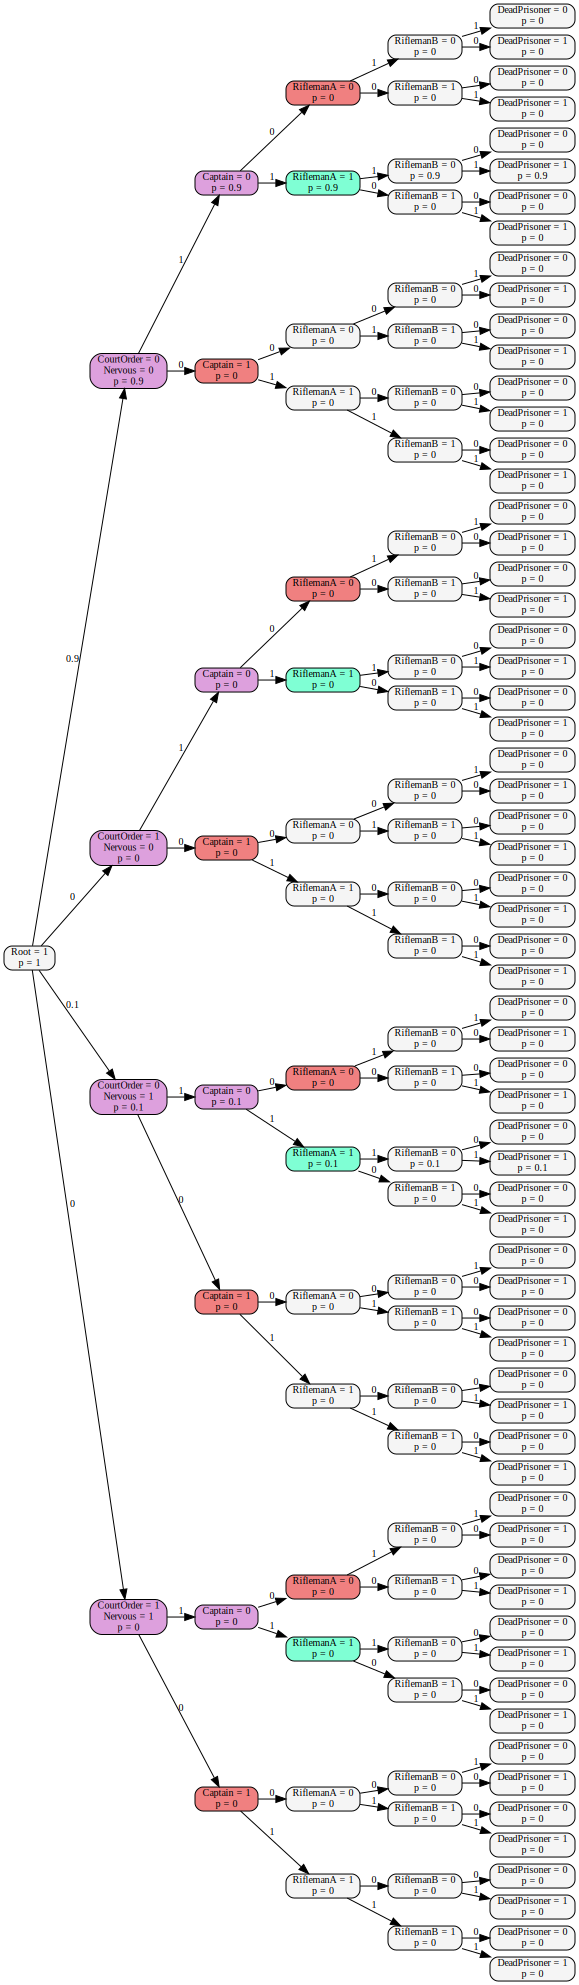

In [190]:
print('\nConditional probability tree:')
display(s4_see_not_C_do_A.show(show_prob=True, cut=not_C & A, crit=fs.critical(not_C & A)))
#display(s4_cf.show(show_prob=True, cut=fs.prop('RiflemanB = 1')))

## S5 Counterfactual

If the prisoner is dead, then the prisoner would be dead even if rifleman A had not shot

In [186]:
D = fs.prop('DeadPrisoner=1')
indicative_premise = fs.see(D)
subjunctive_cut = fs.prop("RiflemanA=0")
s5_counterfactual = fs.cf(indicative_premise, subjunctive_cut)
display(Latex('$$P(D_{\lnot A} | D ) = %f$$' % 
      s5_counterfactual.prob(fs.prop('DeadPrisoner=1') )))



<IPython.core.display.Latex object>

# Nervous Firing squad 

Assumptions:
1.   there is a probability $P(U) = p$ that the court has ordered the execution;
2.   rifleman A has a probability $q$ of pulling the trigger out of nervousness; and
3.   rifleman A’s nervousness is independent of $U$.

## Nervous firing squad

In [169]:
def nervous_firing_squad(bvar):
    # Define the Court order and Nervous Rifleman A events.
    #new_bvars = None
    if 'CourtOrder' not in bvar and 'Nervous' not in bvar:
        p = 0.5   # Probability of Court Order
        q = 0.1
        return [((1-p)*(1-q),'CourtOrder=0,Nervous=0'), 
                (    p*(1-q),'CourtOrder=1,Nervous=0'),
               ( (1-p)*q,    'CourtOrder=0,Nervous=1'),
               (     p*q,    'CourtOrder=1,Nervous=1')]
    
    elif 'Captain' not in bvar:
        if bvar['CourtOrder'] == '0':
            return [(1,'Captain=0'),
                    (0,'Captain=1')]
        else:
            return [(0,'Captain=0'),
                    (1,'Captain=1')]
    elif 'RiflemanA' not in bvar:
        if bvar['Captain'] == '0' and bvar['Nervous'] == '0':
            return [(1,'RiflemanA=0'),
                    (0,'RiflemanA=1'),
                    ]
        else:
            return [(0,'RiflemanA=0'),
                    (1,'RiflemanA=1'),
                    ]
    elif 'RiflemanB' not in bvar:
        if bvar['Captain'] == '0':
            return [(1,'RiflemanB=0'),
                    (0,'RiflemanB=1'),
                    ]
        else:
            return [(0,'RiflemanB=0'),
                    (1,'RiflemanB=1'),
                    ]
    elif 'DeadPrisoner' not in bvar:
        if bvar['RiflemanA']  == '0' and bvar['RiflemanB'] == '0':
            return [(1,'DeadPrisoner=0'),
                    (0,'DeadPrisoner=1')]
        else:
            return [(0,'DeadPrisoner=0'),
                    (1,'DeadPrisoner=1')]

    else:
        return None


## Probability tree

Random variables: {'Root': ['1'], 'CourtOrder': ['0', '1'], 'Nervous': ['0', '1'], 'Captain': ['0', '1'], 'RiflemanA': ['0', '1'], 'RiflemanB': ['0', '1'], 'DeadPrisoner': ['0', '1']}

P(DeadPrisoner) = [(0.45, '0'), (0.55, '1')]

Original probability tree:


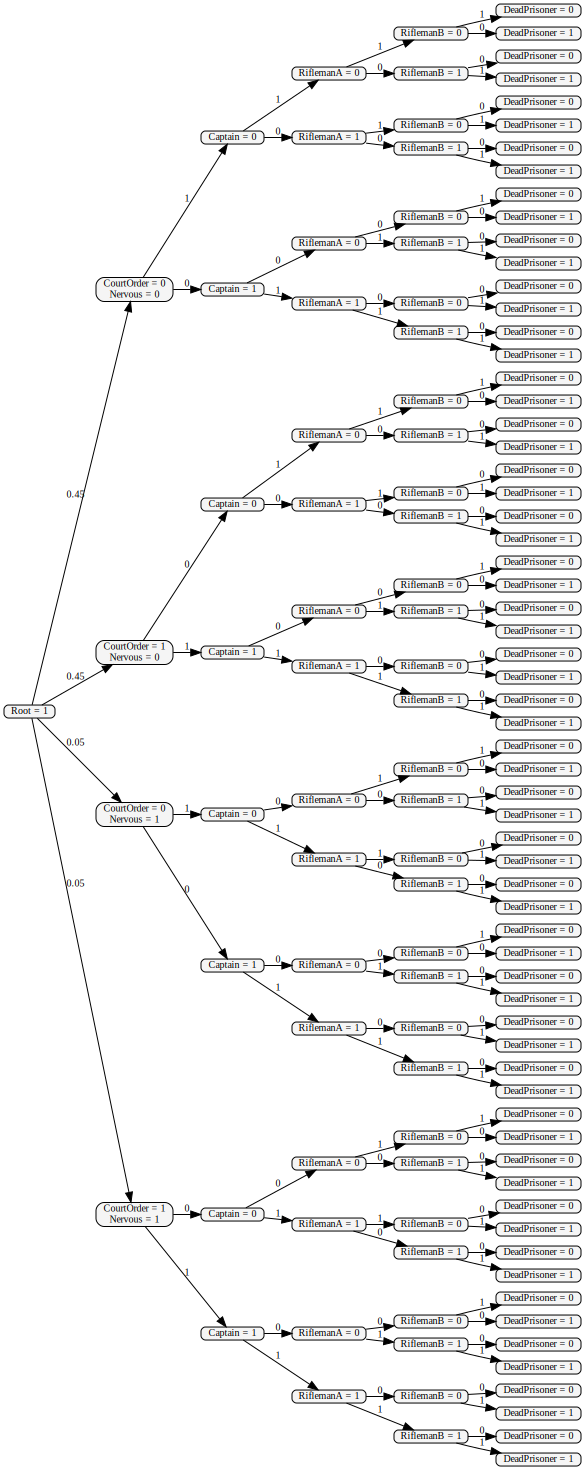


Some samples from the probability tree:
{'Root': '1', 'CourtOrder': '0', 'Nervous': '0', 'Captain': '0', 'RiflemanA': '0', 'RiflemanB': '0', 'DeadPrisoner': '0'}
{'Root': '1', 'CourtOrder': '1', 'Nervous': '0', 'Captain': '1', 'RiflemanA': '1', 'RiflemanB': '1', 'DeadPrisoner': '1'}
{'Root': '1', 'CourtOrder': '1', 'Nervous': '0', 'Captain': '1', 'RiflemanA': '1', 'RiflemanB': '1', 'DeadPrisoner': '1'}
{'Root': '1', 'CourtOrder': '0', 'Nervous': '0', 'Captain': '0', 'RiflemanA': '0', 'RiflemanB': '0', 'DeadPrisoner': '0'}
{'Root': '1', 'CourtOrder': '0', 'Nervous': '0', 'Captain': '0', 'RiflemanA': '0', 'RiflemanB': '0', 'DeadPrisoner': '0'}


In [170]:
fs = PTree.fromFunc(nervous_firing_squad, 'Root = 1')

# Print all the random variables.
print('Random variables:', fs.rvs())
print('\nP(DeadPrisoner) =', fs.rv('DeadPrisoner'))

print('\nOriginal probability tree:')
display(fs.show())

print('\nSome samples from the probability tree:')
for k in range(5):
  print(fs.sample())

##  S6 Probabilistic counterfactual

With these assumptions, we wish to compute the quantity $P(\lnot D_{\lnot A}|D)$ namely, the probability that the prisoner would be alive if A had not shot, given that the prisoner is in fact dead.

Intuitively, we can figure out the answer by noting that $\lnot D_{\lnot A}$  is true if and only if the court has not issued an order. Thus, our task amounts to that of computing , which evaluates to $\frac{q(1 - p)}{[1 - (1 - q)(1 - p)]}$. However, our aim is to demonstrate a general and formal method of deriving such probabilities, based on (7.4), that makes little use of intuition.


Pearl, Judea. Causality (p. 212). Cambridge University Press. Kindle Edition. 

In [198]:

p,q = 0.5, 0.1
D_star = (q*(1-p))/(1- (1-q)*(1-p))
D_star

0.09090909090909091

If  $p=0.5$ and $q=0.1$, then $$P(\lnot D_{\lnot A}|D) = \frac{q(1 - p)}{[1 - (1 - q)(1 - p)]}  = 0.090909...$$

In [182]:
from IPython.display import Latex
D = fs.prop('DeadPrisoner=1')
indicative_premise = fs.see(D)
subjunctive_cut = fs.prop("RiflemanA=0")
s6_counterfactual = fs.cf(indicative_premise, subjunctive_cut)


display(Latex('$P(\lnot D_{\lnot A} | D ) = %f$' % 
      s6_counterfactual.prob(fs.prop('DeadPrisoner=0') )))


<IPython.core.display.Latex object>